In [1]:
import os, sklearn, pandas, numpy as np, random
from sklearn import svm
import skimage, skimage.io, skimage.filters
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set cwd back to default
os.chdir('../')
os.getcwd()

'/Users/mark/src/dog-breed-identification/src'

In [3]:
## NN libs
import keras
from sklearn.decomposition import PCA
from keras.utils import to_categorical
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Conv3D, MaxPool2D, Dropout, Flatten
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [4]:
# custom scripts
import config # params, constants
import data, models # functions that mutate outr data
from utils import utils, plot # custom functions, in local environment

 Dataset :: namedtuple(
    ['train' = ['img_name']
    , 'test' = ['img_name']
    , 'labels' = pandas.df('img_name','breed')
    , 'dict_index_to_label' = dict to convert label_index -> label_name
    , 'dict_label_to_index'= dict to convert label_name -> label_index
    


# Prepare dataset

In [5]:
import data # src/data.py
dataset = data.init_dataset()

### Select the amount of classes that will be used

In [6]:
# pick the n classes with the most occuring instances
amt = 3
classes = data.top_classes(dataset.labels, amt)
classes

['scottish_deerhound', 'maltese_dog', 'afghan_hound']

In [7]:
name_list = []
n_per_class = []
tail = '.jpg'
for cls in classes:
    names = data.items_with_label(dataset.labels, cls)
    train_names = [f for f in names if (f + tail) in dataset.train]
    name_list.append(train_names)
    n_per_class.append(len(train_names))
    
n = min(n_per_class)
# (optional) reduce n to check whether the model can rember its input
reduced_n = 50
if n > reduced_n:    n = reduced_n
x = []
for ls in name_list:
    for name in ls[:n]:
        x.append(name)
random.shuffle(x)
len(x)

150

In [8]:
# TODO rmv faces

## Load & convert images
All input images should have the same size

In [9]:
# TODO use crop
# TODO first 
x_train, y_train, n = data.extract_all(dataset, x)
n

extract all data: 150


145

In [10]:
data.show_info(x_train)

__ info: __
length:  145
type:  <class 'numpy.ndarray'>
shape:  (145, 250, 250, 3)


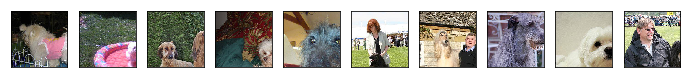

In [11]:
plot.multiple(x_train[:10])

### Prepare the labels

Encode the labels to one-hot vectors

In [12]:
# TODO y_test
y_test = y_train
y_train, y_test = data.labels_to_vectors(dataset, y_train, y_test)

In [13]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.])

# Train a Sequential model (keras)

In [14]:
n_samples = x_train.shape[0] # = length of the list of images (matrices)
input_shape = x_train.shape[1:] # = shape of an individual image (matrix)
output_length = (y_train[0]).shape[0] # = length of an individual label
print(n_samples, input_shape)
print('output length', output_length)

145 (250, 250, 3)
output length 108


In [15]:
x_train.shape

(145, 250, 250, 3)

In [16]:
input_shape

(250, 250, 3)

In [23]:
def sequential_conv(input_shape, output_length, dropout=0.10):
    # Convolutional layers
    model = Sequential()
    model.add(Conv2D(4, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(8, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2))) # strides=(2,2) - watch dims!?!
    model.add(Conv2D(32, (9, 9), activation='relu'))
    # reduce the number of dimensions
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(8, (6, 6), activation='relu'))
    model.add(Dropout(dropout))  
    # Dense layers
    model.add(Flatten())  
    # model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    # model.add(Dense(16, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(output_length,activation='softmax'))
    return model, model.summary

dropout = 0.10
model, summary = sequential_conv(input_shape, output_length, dropout)
summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 248, 248, 4)       112       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 246, 246, 8)       296       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 123, 123, 8)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 115, 115, 32)      20768     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 57, 57, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 52, 52, 8)         9224      
_________________________________________________________________
dropout_3 (Dropout)          (None, 52, 52, 8)         0         
__________

In [24]:
# model, summary = models.sequential_conv(input_shape, output_length)
# summary()

## Loss function
- Categorical cross-entropy loss

In [25]:
learning_rate = 0.001
# Adam, SGD
# sgd = Keras.optimizers.SGD(lr=0.01, clipnorm=1.)
optimizer = Adam(lr=learning_rate)
# top_k_categorical_accuracy(y_true, y_pred, k=5)
# https://keras.io/metrics/
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',
    'mean_squared_error','categorical_crossentropy','top_k_categorical_accuracy'])
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

## Train the model

In [26]:
batch_size = 8
# n epochs = n iterations over all the training data
epochs = 10

In [27]:
config.tmp_model_dir

'/tmp/ml_model'

In [28]:
# model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=1/6)
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
          validation_split=1/5, callbacks=[TensorBoard(log_dir=config.tmp_model_dir)])

Train on 116 samples, validate on 29 samples
Epoch 1/10
116/116 [==============================] - 15s 132ms/step - loss: 11.5134 - acc: 0.2845 - mean_squared_error: 0.0131 - categorical_crossentropy: 11.5134 - top_k_categorical_accuracy: 0.9224 - val_loss: 9.4485 - val_acc: 0.4138 - val_mean_squared_error: 0.0109 - val_categorical_crossentropy: 9.4485 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/10
116/116 [==============================] - 13s 116ms/step - loss: 11.2549 - acc: 0.3017 - mean_squared_error: 0.0129 - categorical_crossentropy: 11.2549 - top_k_categorical_accuracy: 1.0000 - val_loss: 9.4485 - val_acc: 0.4138 - val_mean_squared_error: 0.0109 - val_categorical_crossentropy: 9.4485 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/10
116/116 [==============================] - 11s 98ms/step - loss: 11.2549 - acc: 0.3017 - mean_squared_error: 0.0129 - categorical_crossentropy: 11.2549 - top_k_categorical_accuracy: 1.0000 - val_loss: 9.4485 - val_acc: 0.4138 - val_mean_squar

In [29]:
result = model.predict(x_train[:10])
# result

In [ ]:
result[0]

i = result[0].argmax()
result[0][i]

In [ ]:
np.mean(np.array(result[0]))